In [1]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt

#from llc_plotter import LLCMapper

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43487 Dashboard: /user/0000-0002-1702-0097/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [15]:
def cov_ratio(ds_budg, scale_fac=1e9, ddof=1):
    ds = xr.Dataset(data_vars={})
    tnd = scale_fac * ds_budg.tnd
    tnd_var = tnd.var(dim='time', ddof=ddof)
    for varname in ds_budg.data_vars:
        if varname in ['tnd', 'vdif', 'hdif']:
            continue
        y = scale_fac * ds_budg[varname]
        cov_ratio = (tnd-tnd.mean('time')).dot(y-y.mean('time'), dims='time') / (ds_budg.dims['time']-ddof) / tnd_var
        ds[varname] = cov_ratio
    return ds

### Load datasets

#### ECCOv4r3 main diagnistics

In [3]:
from intake import open_catalog

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [4]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ecco  = cat["ECCOv4r3"].to_dask()

#### ECCOv4r3 heat anomaly budget

In [5]:
gcs = gcsfs.GCSFileSystem(requester_pays=True)  

In [6]:
# Heat anomaly budget 
budgH = xr.open_zarr(gcs.get_mapper('gs://pangeo-ecco-eccov4r3/budgets/eccov4r3_anom_budgH'))

### Calculate volume and find maximum MLD

In [7]:
coords = ecco.coords.to_dataset().reset_coords()

In [8]:
# Volume (m^3)
vol = (coords.rA*coords.drF*coords.hFacC).transpose('face','k','j','i')

#### Climatological MLD in ECCOv4r3

In [16]:
mld = ecco.MXLDEPTH.where(coords.hFacC[0].values==1)

In [24]:
# Climatological MLD
mld_clim = mld.groupby('time.month').mean('time')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [25]:
# Maximum Climatological MLD
mld_clim_max = mld_clim.max('month')

### Depth-average over maximum climatolgocal MLD

In [26]:
budgH_aveMLD = budgH.where(coords.Z > -mld_clim_max).sum('k')/vol.where(coords.Z > -mld_clim_max).sum('k')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs
/srv/conda/envs/notebo

### Add terms

In [28]:
# Add vertical and horizontal component for diffusion and the nonlinear advection term
budgH_aveMLD['dif'] = budgH_aveMLD.hdif + budgH_aveMLD.vdif
budgH_aveMLD['adv_Uanom_Tanom'] = budgH_aveMLD.hadv_Uanom_Tanom + budgH_aveMLD.vadv_Uanom_Tanom

# Add vertical and horizontal components of linear advection terms
budgH_aveMLD['adv_Uanom_Tclim'] = budgH_aveMLD.hadv_Uanom_Tclim+budgH_aveMLD.vadv_Uanom_Tclim
budgH_aveMLD['adv_Uclim_Tanom'] = budgH_aveMLD.hadv_Uclim_Tanom+budgH_aveMLD.vadv_Uclim_Tanom

# Total advection
budgH_aveMLD['adv'] = budgH_aveMLD.adv_Uanom_Tclim+budgH_aveMLD.adv_Uclim_Tanom+budgH_aveMLD.adv_Uanom_Tanom

# Total sum of terms
budgH_aveMLD['total'] = budgH_aveMLD.frc+budgH_aveMLD.adv+budgH_aveMLD.dif+budgH_aveMLD.res

### Ratio of covariance over variance

In [35]:
corr = cov_ratio(budgH_aveZ).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/srv/conda/en

KeyboardInterrupt: 

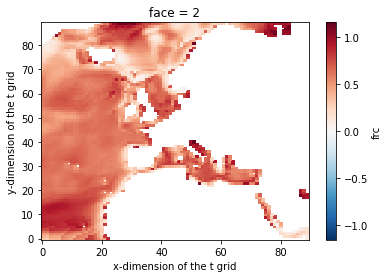

In [34]:
corr.frc[2].plot()

### Depth-average over constant level

In [9]:
budgH.coords['vol'] = vol
budgH.coords['Z'] = coords.Z

In [10]:
budgH = budgH.swap_dims({'k':'Z'})

In [11]:
z_lower = 700
print('Deepest depth layer at',budgH.sel(Z=slice(0,-z_lower)).Z[-1].values,' m')

Deepest depth layer at -634.735  m


In [12]:
budgH_aveZ = budgH.sel(Z=slice(0,-z_lower)).sum('Z')/budgH.sel(Z=slice(0,-z_lower)).vol.sum('Z')

In [13]:
# Add vertical and horizontal component for diffusion and the nonlinear advection term
budgH_aveZ['dif'] = budgH_aveZ.hdif + budgH_aveZ.vdif
budgH_aveZ['adv_Uanom_Tanom'] = budgH_aveZ.hadv_Uanom_Tanom + budgH_aveZ.vadv_Uanom_Tanom

# Add vertical and horizontal components of linear advection terms
budgH_aveZ['adv_Uanom_Tclim'] = budgH_aveZ.hadv_Uanom_Tclim+budgH_aveZ.vadv_Uanom_Tclim
budgH_aveZ['adv_Uclim_Tanom'] = budgH_aveZ.hadv_Uclim_Tanom+budgH_aveZ.vadv_Uclim_Tanom

# Total sum of terms
budgH_aveZ['total'] = budgH_aveZ.adv_Uanom_Tclim+budgH_aveZ.adv_Uclim_Tanom+budgH_aveZ.dif\
                        +budgH_aveZ.frc+budgH_aveZ.adv_Uanom_Tanom+budgH_aveZ.res

In [16]:
corr = cov_ratio(budgH_aveZ)

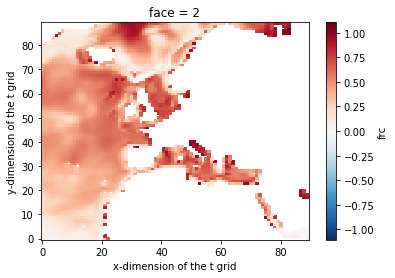

In [19]:
corr.frc[2].plot()